# Yield Spread Z Score Strategy

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FallenAngel\root\src")
from RiskPremia import RiskPremia

## Generate Signal

In [3]:
def _get_zscore(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            roll_mean  = lambda x: x.spread_val.ewm(span = window, adjust = False).mean(),
            roll_std   = lambda x: x.spread_val.ewm(span = window, adjust = False).std(),
            z_score    = lambda x: (x.spread_val - x.roll_mean) / x.roll_std,
            lag_zscore = lambda x: x.z_score.shift()).
        dropna().
        drop(columns = ["roll_mean", "roll_std", "z_score"]))
    
    return df_out

def generate_signal(window: int = 10) -> pd.DataFrame: 

    df_tmp = (RiskPremia().get_yld_spread().groupby(
        ["spread", "variable"]).
        apply(_get_zscore, window).
        reset_index(drop = True)
        [["date", "variable", "angl_ticker", "bnd_ticker", "lag_zscore", "spread"]].
        rename(columns = {
            "angl_ticker": "angl_sec",
            "bnd_ticker" : "bnd_sec",
            "spread"     : "ticker_spread"}).
        assign(date = lambda x: pd.to_datetime(x.date)))
    
    return df_tmp

df_signal = generate_signal()

## Equal Weight Spread

In [4]:
def get_signal_equal_rtn(df_signal: pd.DataFrame) -> pd.DataFrame: 

    df_signal = (RiskPremia().calculate_equal_spread().assign(
        date = lambda x: pd.to_datetime(x.date)).
        merge(right = df_signal, how = "inner", on = ["date", "bnd_sec", "angl_sec"]).
        assign(
            signal_rtn = lambda x: np.sign(x.lag_zscore) * x.spread,
            bond_group = lambda x: np.where((x.bnd_sec == "AGG") | (x.bnd_sec == "LQD"), "Investment Grade", "High Yield")))
    
    return df_signal

df_equal_signal = get_signal_equal_rtn(df_signal)

In [6]:
(df_equal_signal.query(
    "bond_group =='High Yield'")
    [["variable", "signal_rtn"]].
    query("variable == variable.min()").
    groupby("variable").
    agg(["mean", "std"])
    ["signal_rtn"].
    reset_index().
    rename(columns = {
        "mean": "mean_rtn",
        "std" : "std_rtn"}).
    assign(is_sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)))

,variable,mean_rtn,std_rtn,is_sharpe
0,ISPREAD,0.000262,0.002961,1.402374


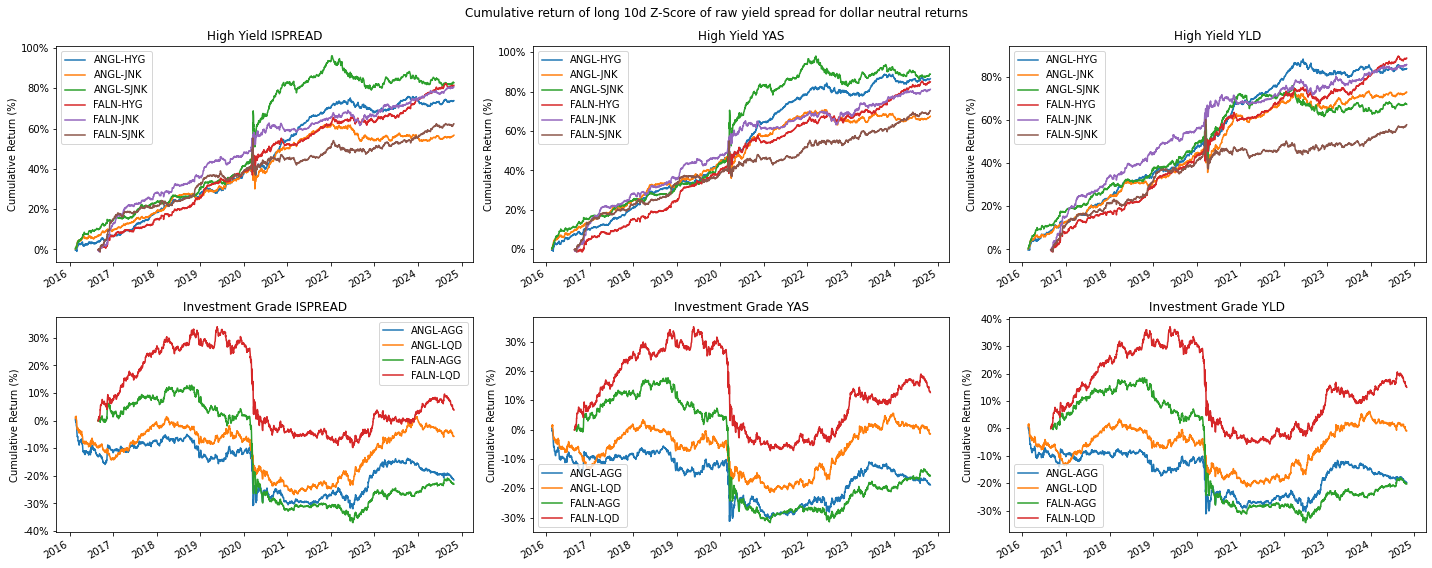

In [7]:
def plot_equal_rtn(df_equal_signal: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_equal_signal.assign(
        group_var = lambda x: x.bond_group + " " + x.variable))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_tmp.query(
            "group_var == @group_var").
            assign(ticker_spread = lambda x: x.ticker_spread.str.replace("_", "-")).
            rename(columns = {"ticker_spread": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                title  = group_var,
                ax     = ax,
                xlabel = "",
                ylabel = "Cumulative Return (%)"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle("Cumulative return of long 10d Z-Score of raw yield spread for dollar neutral returns")
    plt.tight_layout()
    
plot_equal_rtn(df_equal_signal)

In [8]:
def get_equal_sharpe(df_equal_signal: pd.DataFrame) -> pd.DataFrame: 

    df_sharpe = (df_equal_signal[
        ["bond_group", "variable", "ticker_spread", "signal_rtn"]].
        groupby(["bond_group", "variable", "ticker_spread"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_equal_sharpe = get_equal_sharpe(df_equal_signal)

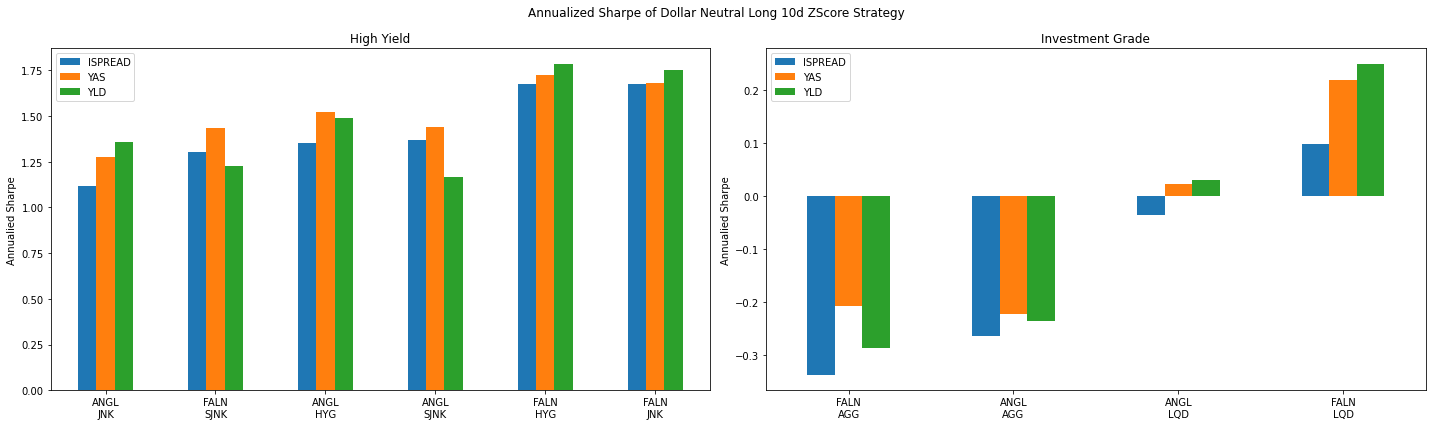

In [9]:
def plot_equal_sharpe(df_equal_sharpe: pd.DataFrame) -> plt.Figure:
    
    variables = df_equal_sharpe.bond_group.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()):

        (df_equal_sharpe.query(
            "bond_group == @variable").
            assign(ticker_spread = lambda x: x.ticker_spread.str.replace("_", "\n")).
            rename(columns = {"variable": ""}).
            pivot(index = "ticker_spread", columns = "", values = "sharpe").
            sort_values("ISPREAD").
            plot(
                rot    = 0,
                ax     = ax,
                kind   = "bar",
                ylabel = "Annualied Sharpe",
                title  = variable,
                xlabel = ""))

    fig.suptitle("Annualized Sharpe of Dollar Neutral Long 10d ZScore Strategy")
    plt.tight_layout()
    
plot_equal_sharpe(df_equal_sharpe)

In [10]:
def _get_ols(df: pd.DataFrame) -> pd.DataFrame:
    
    model = (sm.OLS(
        endog = df.spread,
        exog  = sm.add_constant(df.lag_zscore)).
        fit())
    
    df_val = (model.params.to_frame(
        name = "val").
        reset_index().
        rename(columns = {"index": "param"}))
    
    df_pval = (model.pvalues.to_frame(
        name = "pval").
        reset_index().
        rename(columns = {"index": "param"}))
    
    df_out = (df_val.merge(
        right = df_pval, how = "inner", on = ["param"]))
    
    return df_out

def get_ols_params(df_equal_signal: pd.DataFrame) -> pd.DataFrame: 

    df_params = (df_equal_signal.assign(
        group_var = lambda x: x.ticker_spread + " " + x.variable).
        groupby(["group_var", "bond_group"]).
        apply(_get_ols).
        reset_index().
        drop(columns = ["level_2"]))
    
    return df_params

df_params = get_ols_params(df_equal_signal)

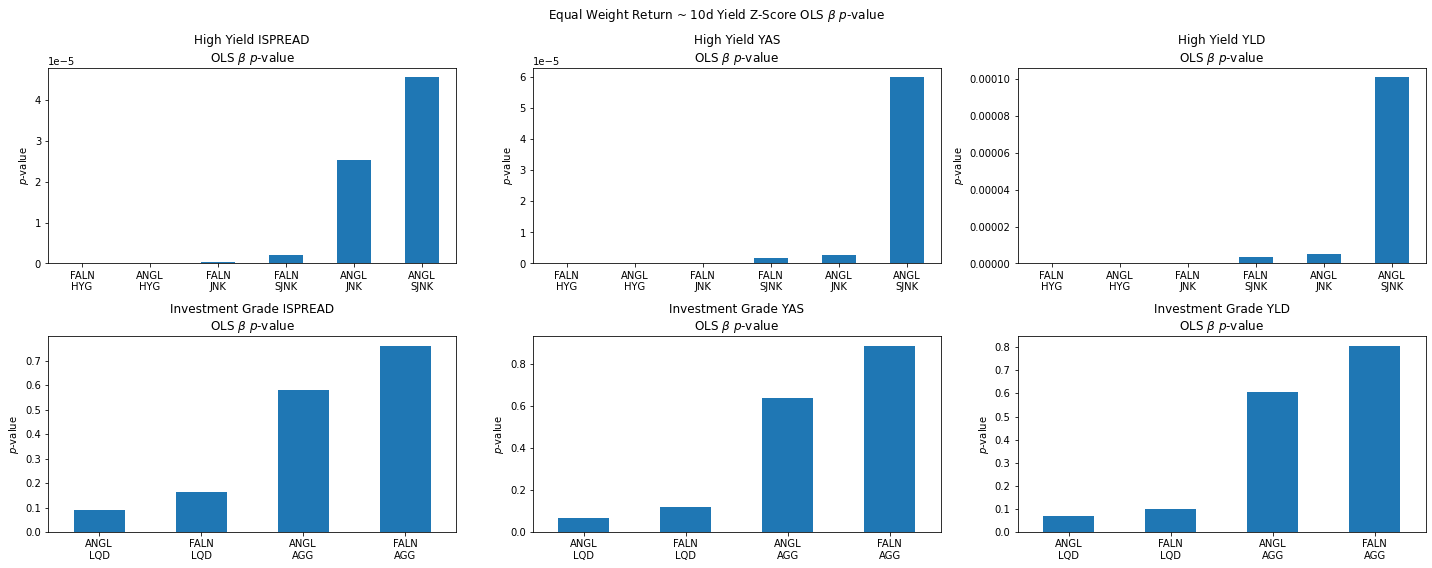

In [11]:
def plot_equal_weight_ols_pvalue(df_params: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_params.query(
        "param == 'lag_zscore'").
        assign(
            spread   = lambda x: x.group_var.str.split(" ").str[0],
            variable = lambda x: x.group_var.str.split(" ").str[1]).
        drop(columns = ["group_var"]).
        assign(group_var = lambda x: x.bond_group + " " + x.variable))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_tmp.query(
            "group_var == @group_var").
            assign(spread = lambda x: x.spread.str.replace("_", "\n")).
            set_index("spread")
            [["pval"]].
            sort_values("pval").
            plot(
                kind   = "bar",
                legend = False,
                ax     = ax,
                ylabel = r"$p$-value",
                rot    = 0,
                xlabel = "",
                title  = group_var + "\n" + r"OLS $\beta$ $p$-value"))

    fig.suptitle(r"Equal Weight Return ~ 10d Yield Z-Score OLS $\beta$ $p$-value")
    plt.tight_layout()
    
plot_equal_weight_ols_pvalue(df_params)

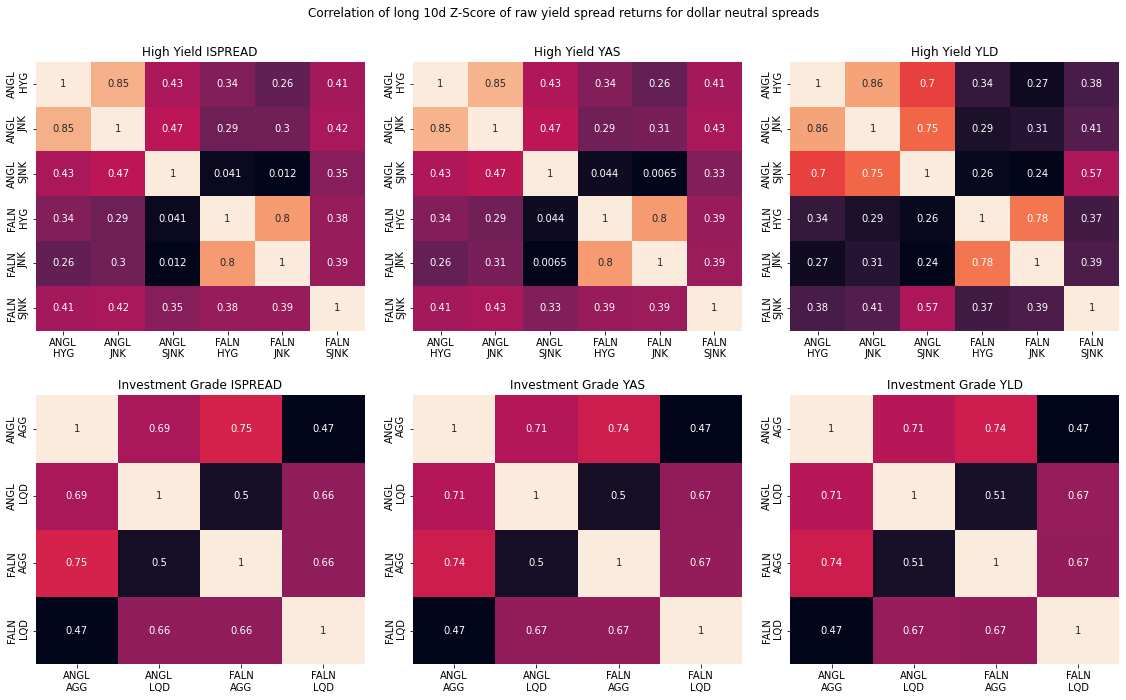

In [12]:
def plot_equal_signal_corr(df_equal_signal: pd.DataFrame) -> plt.Figure: 

    df_tmp = (df_equal_signal.assign(
        group_var = lambda x: x.bond_group + " " + x.variable))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (16,10))

    for group_var, ax in zip(group_vars, axes.flatten()):

        df_plot = (df_tmp.query(
            "group_var == @group_var").
            assign(ticker_spread = lambda x: x.ticker_spread.str.replace("_", "\n")).
            rename(columns = {"ticker_spread": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            corr())

        sns.heatmap(
            data  = df_plot, 
            ax    = ax, 
            annot = True,
            cbar  = False)

        ax.set_title(group_var)

    fig.suptitle("Correlation of long 10d Z-Score of raw yield spread returns for dollar neutral spreads")
    plt.tight_layout(pad = 2)
    
plot_equal_signal_corr(df_equal_signal)

## Duration Neutral Spread

In [13]:
def get_dur_signal(df_signal: pd.DataFrame) -> pd.DataFrame:
    
    df_signal = (RiskPremia().calculate_duration_neutral_spread().merge(
        right = df_signal, how = "inner", on = ["bnd_sec", "angl_sec", "date"]).
        assign(
            spread     = lambda x: (x.angl_rtn * x.angl_weight) - (x.bnd_rtn * x.bnd_weight),
            signal_rtn = lambda x: np.sign(x.lag_zscore) * x.spread,
            bnd_group  = lambda x: np.where((x.bnd_sec == "AGG") | (x.bnd_sec == "LQD"), "Investment Grade", "High Yield")))
    
    return df_signal

df_dur_signal = get_dur_signal(df_signal)

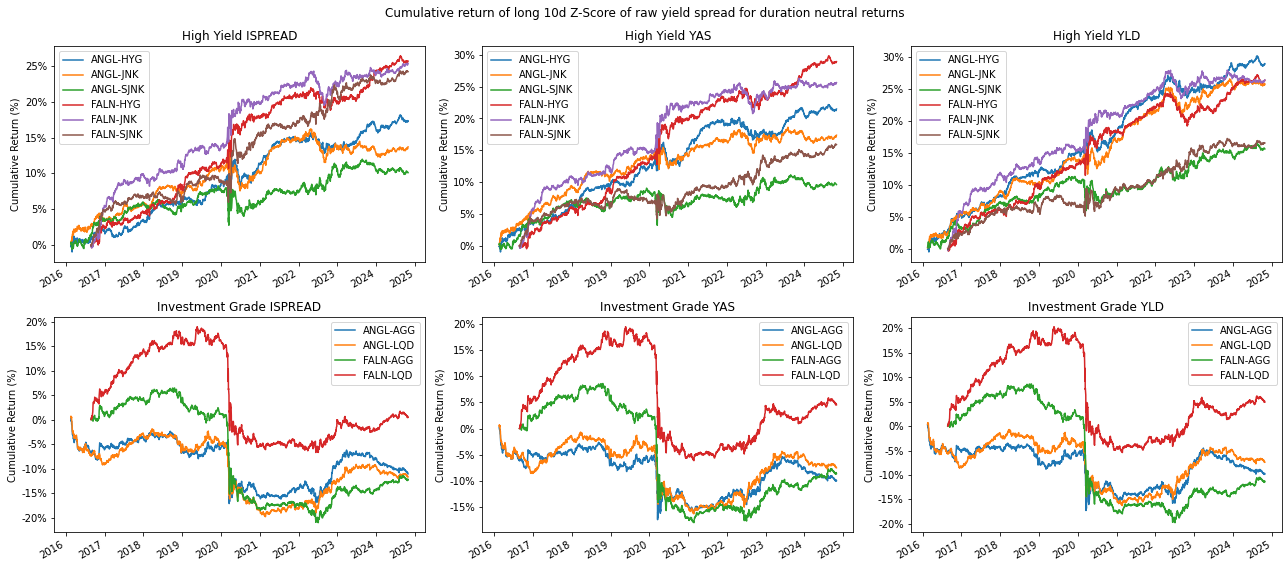

In [14]:
def plot_dur_rtn(df_dur_signal: pd.DataFrame) -> plt.Figure: 
    
    df_plot = (df_dur_signal.assign(
        group_var = lambda x: x.bnd_group + " " + x.variable))

    variables = df_plot.group_var.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 3, figsize = (18,8))

    for variable, ax in zip(variables, axes.flatten()):

        (df_plot.query(
            "group_var == @variable").
            assign(ticker_spread = lambda x: x.ticker_spread.str.replace("_", "-")).
            rename(columns = {"ticker_spread": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                title  = variable,
                ax     = ax,
                ylabel = "Cumulative Return (%)",
                xlabel = ""))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle("Cumulative return of long 10d Z-Score of raw yield spread for duration neutral returns")
    plt.tight_layout()
    
plot_dur_rtn(df_dur_signal)

In [15]:
def get_dur_sharpe(df_dur_signal: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_dur_signal[
        ["ticker_spread", "bnd_group", "signal_rtn", "variable"]].
        groupby(["ticker_spread", "bnd_group", "variable"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_dur_sharpe = get_dur_sharpe(df_dur_signal)

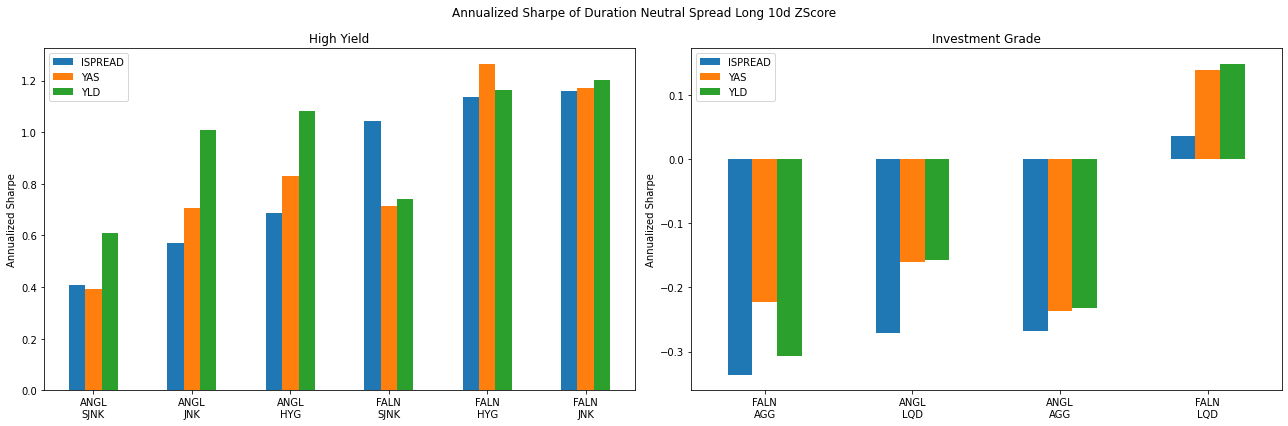

In [16]:
def plot_dur_sharpe(df_dur_sharpe: pd.DataFrame) -> plt.Figure: 
    
    variables = df_dur_sharpe.bnd_group.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (18,6))

    for variable, ax in zip(variables, axes.flatten()):

        (df_dur_sharpe.query(
            "bnd_group == @variable").
            assign(ticker_spread = lambda x: x.ticker_spread.str.replace("_", "\n")).
            rename(columns = {"variable": ""}).
            pivot(index = "ticker_spread", columns = "", values = "sharpe").
            sort_values("ISPREAD").
            plot(
                ax     = ax,
                kind   = "bar",
                rot    = 0,
                ylabel = "Annualized Sharpe",
                title  = variable,
                xlabel = ""))

    fig.suptitle("Annualized Sharpe of Duration Neutral Spread Long 10d ZScore")
    plt.tight_layout()
    
plot_dur_sharpe(df_dur_sharpe)

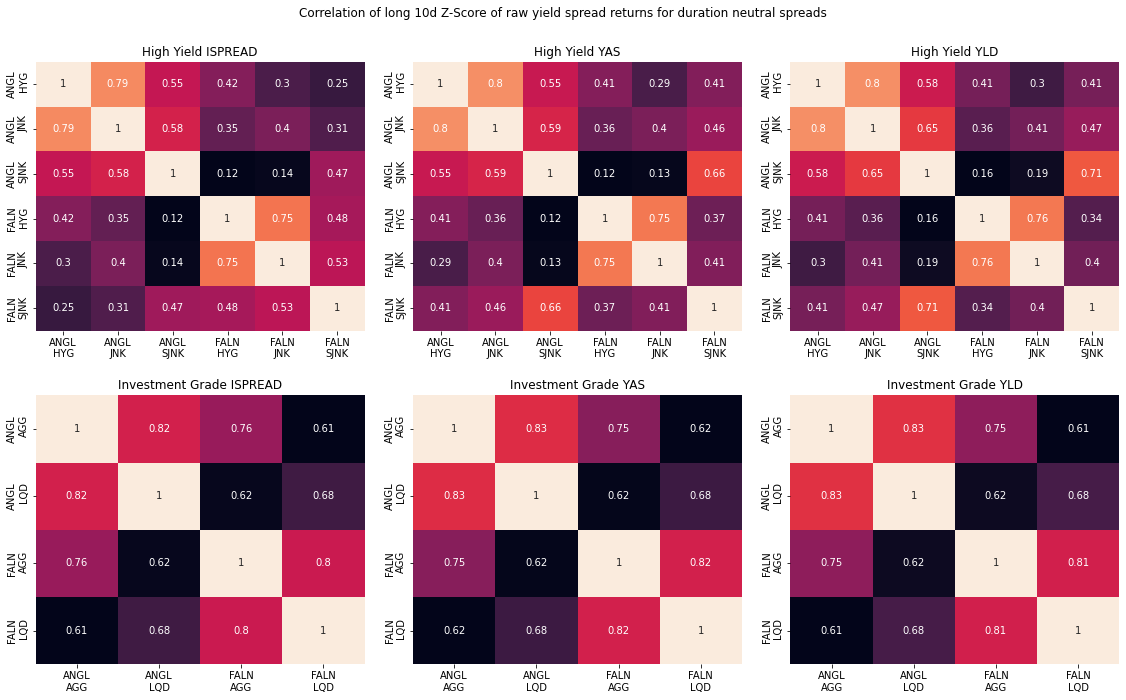

In [17]:
def plot_dur_correlation(df_dur_signal: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_dur_signal.assign(
        group_var = lambda x: x.bnd_group + " " + x.variable))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (16,10))

    for group_var, ax in zip(group_vars, axes.flatten()):

        df_corr = (df_tmp.query(
            "group_var == @group_var").
            assign(ticker_spread = lambda x: x.ticker_spread.str.replace("_", "\n")).
            pivot(index = "date", columns = "ticker_spread", values = "signal_rtn").
            corr())

        sns.heatmap(
            data  = df_corr,
            ax    = ax,
            cbar  = False,
            annot = True)
        
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title(group_var)

    fig.suptitle("Correlation of long 10d Z-Score of raw yield spread returns for duration neutral spreads")
    plt.tight_layout(pad = 2)
    
plot_dur_correlation(df_dur_signal)

In [24]:
def get_port(df_equal_signal: pd.DataFrame, df_dur_signal: pd.DataFrame) -> pd.DataFrame: 

    df_equal_tmp = (df_equal_signal[
        ["date", "bond_group", "signal_rtn", "variable"]].
        assign(spread_tmp = "Dollar Neutral"))

    df_dur_tmp = (df_dur_signal[
        ["date", "bnd_group", "signal_rtn", "variable"]].
        rename(columns = {"bnd_group": "bond_group"}).
        assign(spread_tmp = "Duration Neutral"))

    df_out = (pd.concat([
        df_equal_tmp, df_dur_tmp]).
        groupby(["date", "bond_group", "variable", "spread_tmp"]).
        agg("mean").
        reset_index())
    
    return df_out

df_port = get_port(df_equal_signal, df_dur_signal)

In [44]:
tmp = (df_equal_signal.query(
    "bond_group == 'High Yield'")
    [["date", "variable", "ticker_spread", "signal_rtn"]].
    query("variable == variable.min()").
    pivot(index = "date", columns = "ticker_spread", values = "signal_rtn").
    mean(axis = 1))

print(tmp.mean() / tmp.std() * np.sqrt(252))

2.0619209251281014


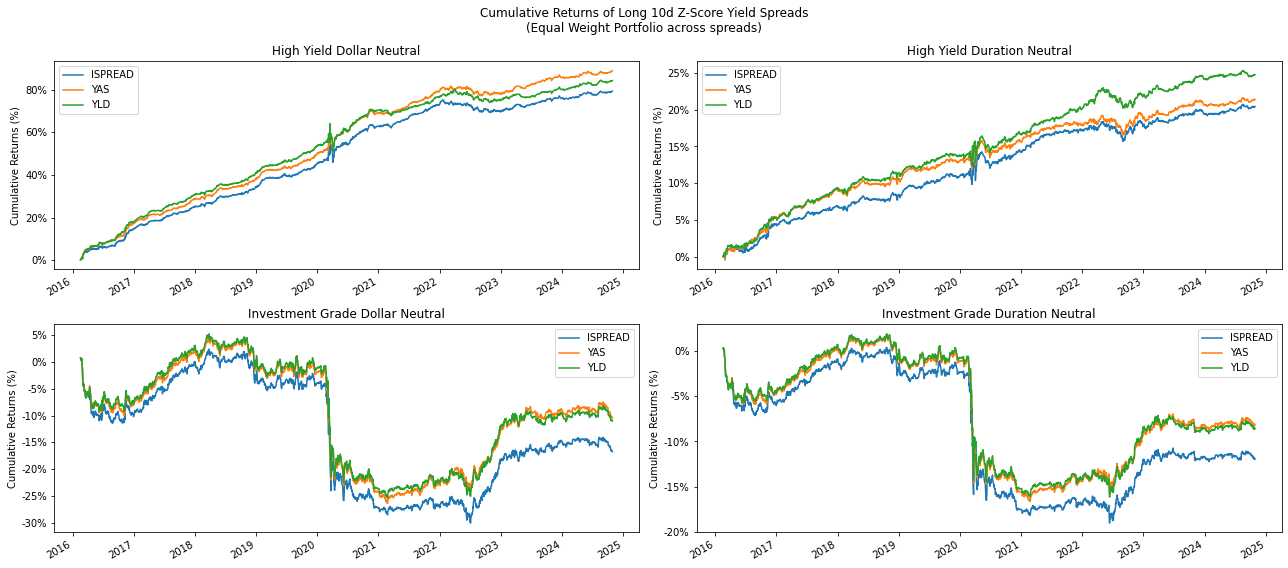

In [19]:
def plot_equal_weight_rtn(df_port: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_port.assign(
        group_var = lambda x: x.bond_group + "_" + x.spread_tmp))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 2, figsize = (18,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_tmp.query(
            "group_var == @group_var").
            rename(columns = {"variable": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                ylabel = "Cumulative Returns (%)",
                title  = group_var.replace("_", " "),
                xlabel = ""))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
    
    fig.suptitle("Cumulative Returns of Long 10d Z-Score Yield Spreads\n(Equal Weight Portfolio across spreads)")
    plt.tight_layout()
    
plot_equal_weight_rtn(df_port)

In [20]:
def get_port_sharpe(df_port: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_port.drop(
        columns = ["date"]).
        groupby(["bond_group", "variable", "spread_tmp"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_port_sharpe = get_port_sharpe(df_port)

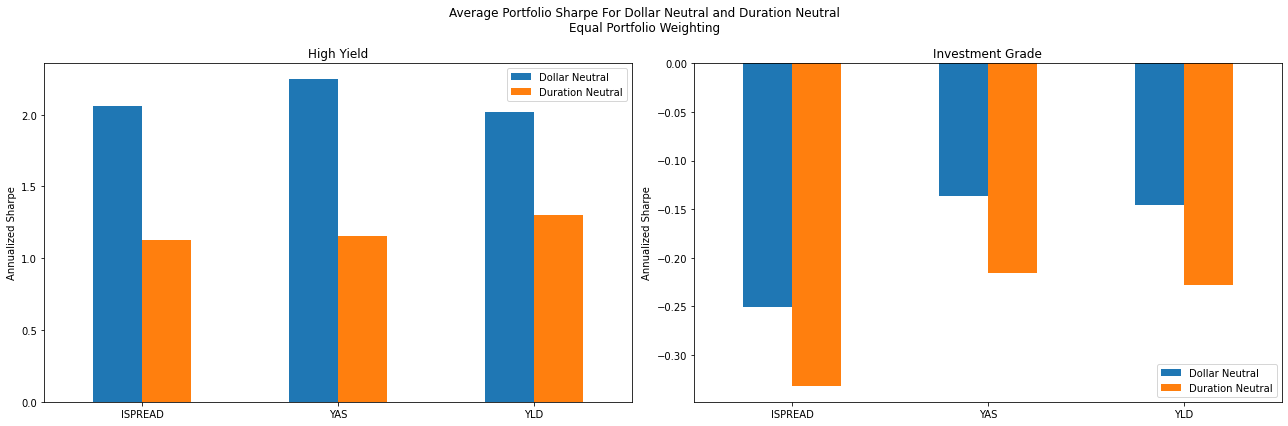

In [21]:
def plot_sharpe(df_port_sharpe: pd.DataFrame) -> plt.Figure: 

    variables = df_port_sharpe.bond_group.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (18,6))

    for variable, ax in zip(variables, axes.flatten()):

        (df_port_sharpe.query(
            "bond_group == @variable").
            rename(columns = {"spread_tmp": ""}).
            pivot(index = "variable", columns = "", values = "sharpe").
            plot(
                ax     = ax,
                kind   = "bar",
                rot    = 0,
                ylabel = "Annualized Sharpe",
                title  = variable,
                xlabel = ""))

    fig.suptitle("Average Portfolio Sharpe For Dollar Neutral and Duration Neutral\nEqual Portfolio Weighting")
    plt.tight_layout()
    
plot_sharpe(df_port_sharpe)